**Import libraries**


In [ ]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

from sklearn import preprocessing
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

**Reading data**

In [ ]:
hashed_feature_df = pd.read_csv("/content/hashed_feature.csv")
tabular_data_df = pd.read_csv("/content/tabular_data.csv")
test_df = pd.read_csv("/content/test.csv")
train_df = pd.read_csv("/content/train.csv")

Split data to train and test

In [ ]:
train_tabular_data = tabular_data_df[:49008]
test_tabular_data = tabular_data_df[49008:]

**Data exploration**

In [ ]:
tabular_data_df.shape

(61272, 52)

In [ ]:
tabular_data_df.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,110.0,55.0,0.432017,0.000000,176.78,0.0,0.323712,NaN,147.0,0.0,176.78,55.0,0.248711,0.001373,0.0,0.0,0.0,0.476549,333.60,0.277617,55.0,0.0,55.0,21.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,1.00,55.000000,93.0,5562.0,93.0,0.040283,182.0,0.000000,43.50,0.0,0.0,0.00,0.00,0,0.000000,0.0,55.0,2.0,0.526552,145.0,133.28,0.0
1,0,2,110.0,110.0,0.397517,0.000000,315.42,0.0,0.316798,NaN,135.0,0.0,315.42,110.0,0.261744,-0.002248,0.0,0.0,0.0,0.210951,428.78,0.290904,110.0,0.0,110.0,26.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.77,110.000000,114.0,5532.0,114.0,0.047588,181.0,0.000000,85.45,0.0,0.0,15.75,0.00,0,0.000000,0.0,110.0,1.0,0.481063,130.0,229.97,0.0
2,0,3,110.0,55.0,0.359440,0.000000,354.55,0.0,0.339188,NaN,181.0,0.0,354.48,55.0,0.302164,0.002083,0.0,0.0,0.0,0.058675,526.38,0.284842,55.0,0.0,55.0,36.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.05,85249.281058,135.0,5501.0,136.0,0.051470,180.0,0.000000,122.70,0.0,0.0,0.00,0.07,0,0.000000,0.0,55.0,1.0,0.509598,180.0,231.78,0.0
3,0,4,110.0,55.0,0.285707,0.000000,229.98,0.0,0.415428,NaN,142.0,0.0,229.98,55.0,0.347660,0.005207,0.0,0.0,0.0,0.966854,398.98,0.285235,55.0,0.0,55.0,30.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.00,55.000000,102.0,5471.0,102.0,0.076190,179.0,0.000000,46.15,0.0,0.0,0.00,0.00,0,0.000000,0.0,55.0,0.0,0.680089,142.0,183.83,0.0
4,0,5,110.0,55.0,0.101487,444.730391,307.12,0.0,0.569670,NaN,92.0,0.0,306.17,55.0,0.438425,0.025736,0.0,21.0,0.0,0.700180,215.17,0.161147,55.0,0.0,55.0,20.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.0,0.00,55.000000,82.0,5440.0,95.0,0.273205,178.0,373.498562,150.33,0.0,0.0,26.75,0.95,0,20.014485,0.0,55.0,0.0,0.776175,85.0,155.83,0.0


In [ ]:
hashed_feature_df.head()

,id,feature_50
0,0,7984b0a0e139cabadb5afc7756d473fb34d23819
1,0,47904b3331202e9881d003ff449c2eabfbc75460
2,0,a99c4b3af723874ddd85af322beea81b64437294
3,0,4dce5381031a88aed6b12ef71b6f7c3148e7b3c8
4,0,d62db721202cb6636887f450a7b77fa97db03b05


In [ ]:
tabular_data_df.describe()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,61272.000000,61272.000000,58460.000000,58380.000000,57795.000000,58314.000000,58425.000000,58257.000000,57814.000000,58280.000000,58338.000000,58344.000000,58318.000000,58184.000000,57847.000000,57938.000000,58366.000000,58410.000000,58193.000000,61272.000000,58212.000000,57708.000000,58331.000000,58463.000000,58399.000000,58173.000000,58321.000000,58604.000000,58373.000000,58274.000000,58810.000000,58457.000000,58354.000000,58270.000000,57494.000000,58387.000000,58255.000000,58445.000000,58409.000000,61272.000000,58415.000000,58402.000000,61272.0,58389.000000,58218.000000,58428.000000,58307.000000,53036.000000,58418.000000,58368.000000,58397.000000
mean,2552.500000,6.500000,110.070493,87.142409,0.305150,3003.454276,414.703826,1466.527398,0.576053,391.127914,125.101255,114.737443,388.728984,1009.457709,0.287931,0.050513,3.155639,10.821589,363.889708,0.499903,417.464495,0.227281,70.269164,11.901861,958.070795,27.880013,3.099158,100.387823,4.873682,20.632075,1851.145168,131.571121,2958.747901,133.563480,0.231423,86.755117,1478.685268,100.235933,4.941925,0.024942,2.864665,2.389240,0.0,451.453999,1.092617,70.045547,12.617404,0.420170,125.407494,288.885904,62.298690
std,1473.987237,3.452081,0.465371,95.507541,0.746314,11218.392268,524.216185,7356.174585,0.738444,436.314898,145.203774,661.855299,512.211932,6182.586735,0.111642,0.087219,24.529224,14.111705,2406.061731,0.289287,445.821333,0.111598,60.744476,54.744476,5974.881448,37.923651,24.016987,119.450853,12.779626,45.393407,11954.561123,149.997946,1723.916883,174.027542,0.161397,70.676962,8254.261078,147.057407,25.539829,0.126317,28.304415,12.291543,0.0,2784.078472,2.989411,60.523556,22.794809,0.402705,123.970687,380.992122,341.761943
min,0.000000,1.000000,110.000000,-4.250000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,-1755.000000,0.000000,0.000000,-1857.710000,0.000000,-1.000000,0.000000,-31.000000,0.000000,0.000001,0.000000,0.000000,0.000000,-4.250000,-4.250000,-300.000000,0.000000,0.000000,0.000000,-464.620000,0.000000,0.000000,0.000000,-2362.000000,0.000000,-227.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-234.610000,0.0,-71832.185113,0.000000,0.000000,0.000000,-0.999903,0.000000,0.000000,0.000000
25%,1276.000000,3.750000,110.000000,45.000000,0.059522,0.000000,70.320000,0.000000,0.247418,99.295000,39.000000,0.000000,54.740000,35.000000,0.207877,0.005089,0.000000,0.000000,0.000000,0.247295,117.420000,0.134781,35.000000,0.000000,45.000000,4.000000,0.000000,23.000000,0.000000,0.220000,0.000000,31.000000,1587.000000,29.000000,0.082152,43.000000,0.000000,9.050000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,35.000000,1.000000,0.084032,39.000000,38.845000,0.000000
50%,2552.500000,6.500000,110.000000,75.000000,0.147504,10.898701,254.950000,0.000000,0.492813,262.430000,100.000000,3.450000,226.960000,70.500000,0.292973,0.021653,0.000000,2.000000,0.000000,0.498526,290.350000,0.223581,62.000000,0.940000,75.000000,19.000000,0.000000,69.000000,0.000000,5.600000,66.000000,92.000000,2489.000000,99.000000,0.213396,79.000000,0.000000,50.480000,0.000000,0.000000,0.000000,0.150000,0.0,0.000000,0.000000,61.580000,5.000000,0.412981,94.000000,168.250000,3.000000
75%,3829.000000,9.250000,110.000000,114.000000,0.321111,1809.999746,566.530000,0.000000,0.698059,535.162500,184.000000,23.300000,529.122500,110.850000,0.364436,0.066905,1.000000,27.000000,1.000000,0.752020,570.907500,0.317355,95.000000,8.400000,116.005000,42.000000,1.0000

In [ ]:
tabular_data_df.dtypes

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerical_df = train_tabular_data.select_dtypes(include=numerics)
categorical_features = ["feature_25"]
numerical_features = numerical_df.dtypes

numerical_features

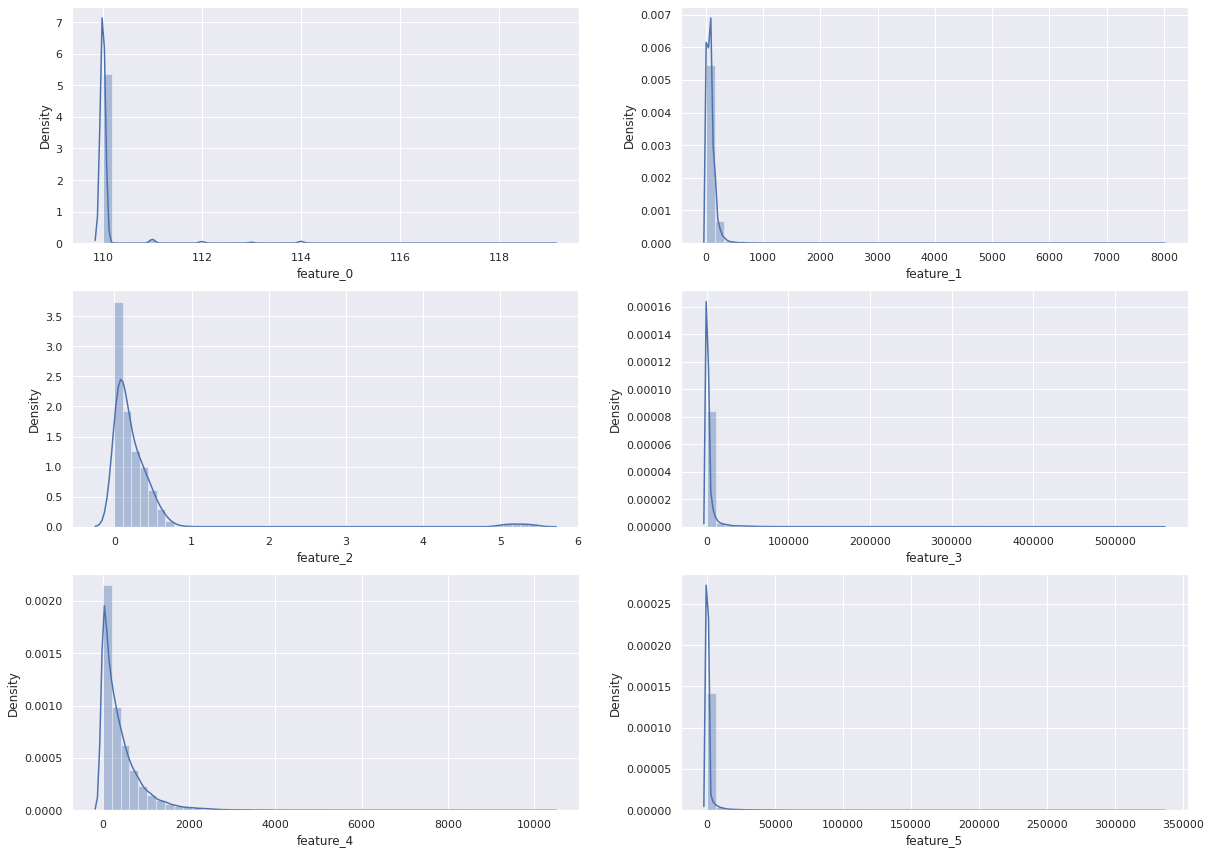

In [ ]:
null_features_numerical = [col for col in tabular_data_df.columns if tabular_data_df[col].isnull().sum() > 0 and col not in categorical_features]
plt.figure(figsize=(20,20))
sns.set()

warnings.simplefilter("ignore")
for i,var in enumerate(null_features_numerical):
  plt.subplot(4,2,i+1)
  sns.distplot(tabular_data_df[var],label="original")
  if (i>=5):
    break

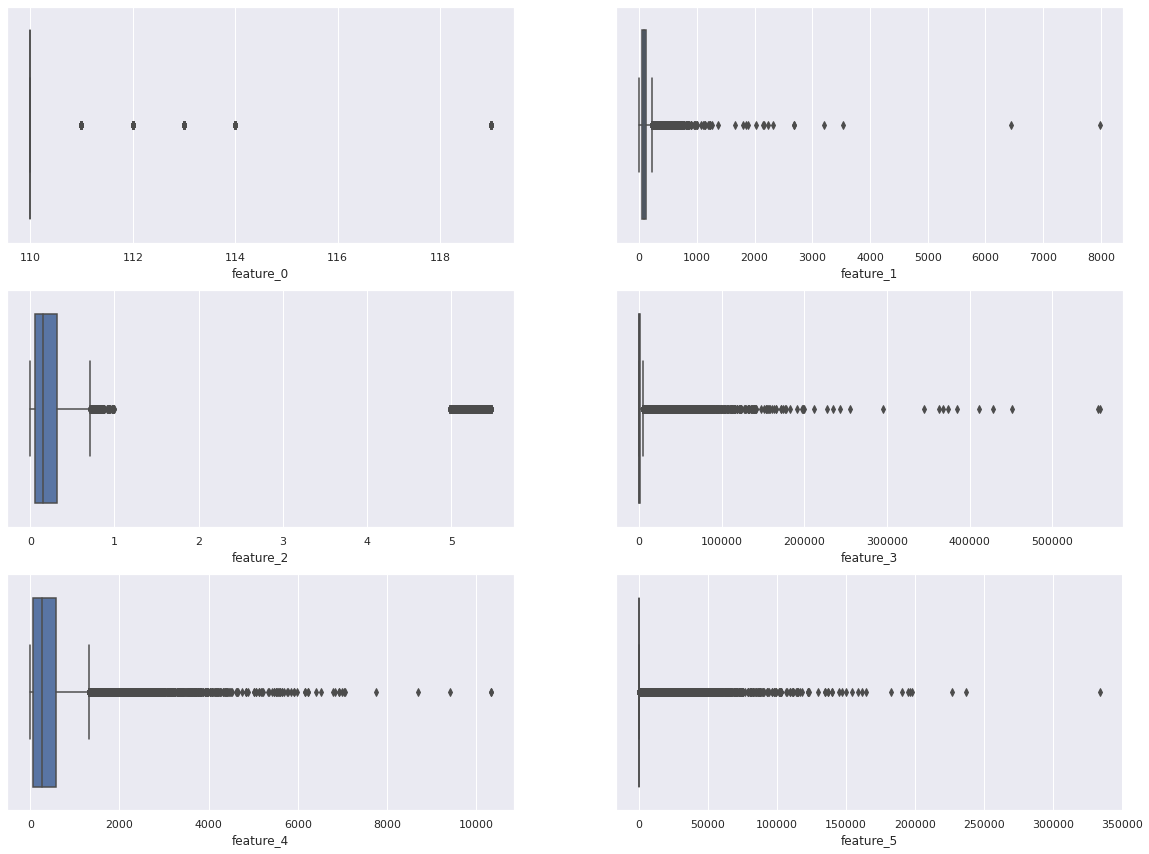

In [ ]:
plt.figure(figsize=(20,20))
sns.set()

warnings.simplefilter("ignore")
for i,var in enumerate(null_features_numerical):
  plt.subplot(4,2,i+1)
  sns.boxplot(tabular_data_df[var])
  if (i>=5):
    break

**Preprocessing**

Let's look at the amount of the missing values in the columns. Maybe we shouldn't take features with the significant percentage of the missing values

In [ ]:
def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    """

    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])

    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

In [ ]:
assess_NA(tabular_data_df)

It seems like percentages of all missing values are not very big and can't lead to the statistical problems. So none of the features should be dropped.

In [ ]:
features = ['feature_1','feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
                   'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_13', 'feature_14', 'feature_15',
                   'feature_16', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23',
                   'feature_24', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
                   'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38',
                   'feature_39', 'feature_40', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
                   'feature_47', 'feature_48', 'feature_49', 'feature_0', 'feature_12']

There are two methods replace NaN values.

In [ ]:
def set_mode(list_of_features):
  for feature in list_of_features:
    False_values = train_tabular_data[feature].loc[train_tabular_data['target']==0]
    True_values = train_tabular_data[feature].loc[train_tabular_data['target']==1]

    mode_false = False_values.mode()
    mode_val_f = mode_false.iloc[0]

    mode_true = True_values.mode()
    mode_val_t = mode_true.iloc[0]

    train_tabular_data[feature] = np.where((train_tabular_data.feature.isnull() == True) & (train_tabular_data.target == 0), 
                                            mode_val_f, train_tabular_data.feature)
    train_tabular_data[feature] = np.where((train_tabular_data.feature.isnull() == True) & (train_tabular_data.target == 1), 
                                            mode_val_t, train_tabular_data.feature)
    
    
def set_median(list_of_features):
    for feature in list_of_features:
      False_values = train_tabular_data[feature].loc[train_tabular_data['target']==0]
      True_values = train_tabular_data[feature].loc[train_tabular_data['target']==1]

      median_val_f = False_values.median()

      median_val_t = True_values.mean()

      train_tabular_data[feature] = np.where((train_tabular_data[feature].isnull() == True) & (train_tabular_data.target == 0), 
                                              median_val_f, train_tabular_data[feature])
      train_tabular_data[feature] = np.where((train_tabular_data[feature].isnull() == True) & (train_tabular_data.target == 1), 
                                              median_val_t, train_tabular_data[feature])

Prepare train data

In [ ]:
train_tabular_data = pd.merge(tabular_data_df, train_df, on='id')

train_tabular_data = train_tabular_data.drop(columns = ['feature_25'])

set_median(features)

train_id_and_period = pd.DataFrame([])
train_id_and_period[['id', 'period']] = train_tabular_data[['id', 'period']]

dropped_cols = ['id', 'period']
train_tabular_data = train_tabular_data.drop(columns=dropped_cols)

RobustScaler is used for normalize data.

In [ ]:
scaler = preprocessing.RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(train_tabular_data),columns = train_tabular_data.columns)

df_scaled = df_scaled.drop(columns=['target'])
df_scaled[['id', 'period']] = train_id_and_period[['id', 'period']]

In [ ]:
def to_1d_data(two_d_df):
  """
  Return dataframe with data converted to 1 dimensional
  """
  one_d_df = pd.DataFrame([])

  for i in range(0,50,1):
    if i==25:
      continue
    for num_period in range(1,13,1):
      one_d_df[str(num_period)+'feature_'+str(i)] = two_d_df['feature_'+str(i)].loc[two_d_df['period'] == num_period].values
  return one_d_df

Convert features to N*M, where N - number of periods, M - number of numerical features

In [ ]:
df_scaled_1d = to_1d_data(df_scaled)

Let's treat *feature_25* and *feature_50* like categorical features.

In [ ]:
hashed_data_f25  = tabular_data_df[:49008].groupby(['id'], as_index=False).agg({'feature_25': pd.Series.nunique})
tabular_data_df = tabular_data_df.drop(columns = ['feature_25'])

id_f25 = pd.DataFrame([])
id_f25['id'] = hashed_data_f25['id']
hashed_data_f25 = hashed_data_f25.drop(columns=['id'])
scaled_f25 = pd.DataFrame(scaler.fit_transform(hashed_data_f25),columns = ['feature_25'])

df_scaled_1d['feature_25'] = scaled_f25['feature_25']

In [ ]:
hashed_f50 = hashed_feature_df[:209312]

hashed_data_f50  = hashed_feature_df[:209312].groupby(['id'], as_index=False).agg({'feature_50': pd.Series.nunique})

id_f50 = pd.DataFrame([])
id_f50['id'] = hashed_data_f50['id']

hashed_data_f50 = hashed_data_f50.drop(columns=['id'])
scaled_f50 = pd.DataFrame(scaler.fit_transform(hashed_data_f50),columns = ['feature_50'])

df_scaled_1d['feature_50']= scaled_f50['feature_50']

In [ ]:
df_scaled_1d

In [ ]:
def set_median_for_test(features):
  for feature in features:
    median = test_tabular_data[feature].median()
    test_tabular_data[feature] = test_tabular_data[feature].fillna(median)

In [ ]:
test_id_and_period = pd.DataFrame([])
test_id_and_period[['id', 'period']] = test_tabular_data[['id', 'period']]

dropped_cols = ['id', 'period']
test_tabular_data = test_tabular_data.drop(columns=dropped_cols)

Fill NaN values

In [ ]:
median_values = test_tabular_data.groupby(np.arange(len(test_tabular_data))//12).median()
median_values['id'] = np.arange(4084,5106)
df_repeated = pd.concat([median_values]*12, ignore_index=True)
df_repeated = df_repeated.sort_values(['id'], ascending=[True])
df_repeated = df_repeated.set_index(np.arange(49008,61272))
test_tabular_data = test_tabular_data.fillna(df_repeated)

set_median_for_test(features)

In [ ]:
test_tabular_data[['id', 'period']] = test_id_and_period[['id', 'period']]

In [ ]:
test_1d = to_1d_data(test_tabular_data)
test_1d

,1feature_0,2feature_0,3feature_0,4feature_0,5feature_0,6feature_0,7feature_0,8feature_0,9feature_0,10feature_0,11feature_0,12feature_0,1feature_1,2feature_1,3feature_1,4feature_1,5feature_1,6feature_1,7feature_1,8feature_1,9feature_1,10feature_1,11feature_1,12feature_1,1feature_2,2feature_2,3feature_2,4feature_2,5feature_2,6feature_2,7feature_2,8feature_2,9feature_2,10feature_2,11feature_2,12feature_2,1feature_3,2feature_3,3feature_3,4feature_3,...,9feature_46,10feature_46,11feature_46,12feature_46,1feature_47,2feature_47,3feature_47,4feature_47,5feature_47,6feature_47,7feature_47,8feature_47,9feature_47,10feature_47,11feature_47,12feature_47,1feature_48,2feature_48,3feature_48,4feature_48,5feature_48,6feature_48,7feature_48,8feature_48,9feature_48,10feature_48,11feature_48,12feature_48,1feature_49,2feature_49,3feature_49,4feature_49,5feature_49,6feature_49,7feature_49,8feature_49,9feature_49,10feature_49,11feature_49,12feature_49
0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,77.66,161.86,85.0,78.0,85.08,102.00,80.00,75.00,93.04,50.12,74.20,35.20,0.494997,0.448919,0.385688,0.365817,0.105262,0.126082,0.139302,0.138572,0.348577,0.372518,0.362720,0.428370,0.000000,0.000000,0.000000,0.000000,...,0.043333,0.038188,0.048722,0.025796,31.0,29.0,151.0,214.0,121.0,162.0,175.0,105.0,85.0,91.0,116.0,138.0,120.75,117.13,93.80,142.47,47.97,274.68,510.30,371.60,106.62,235.53,271.35,145.03,2.0,1.0,2.0,1.0,3.0,1.0,2343.781488,0.0,3.0,0.0,1.0,5.0
1,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,92.00,79.00,75.0,79.0,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,0.257975,0.257975,0.257975,0.257975,0.257975,0.257975,0.257975,0.257975,0.257975,0.257975,0.257975,0.257975,0.000126,0.000042,0.000000,0.000042,...,0.745312,0.745312,0.745312,0.745312,71.0,44.0,15.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,73.27,54.63,18.62,54.63,54.63,54.63,54.63,54.63,54.63,54.63,54.63,54.63,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,60.00,55.00,59.0,112.0,81.00,41.00,55.00,110.00,55.00,55.00,55.00,55.00,0.293105,0.286113,0.224951,0.235954,0.256788,0.171859,0.216296,0.240982,0.234586,0.261015,0.269830,0.298206,0.000000,0.000000,0.000000,0.000000,...,0.027781,0.063297,0.063388,0.030885,332.0,468.0,304.0,328.0,360.0,412.0,361.0,407.0,377.0,355.0,403.0,428.0,598.33,885.03,860.07,475.07,680.37,636.62,1087.37,1007.17,1120.48,1306.25,1163.98,863.58,0.0,1.0,1.0,3.0,7.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
3,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,88.00,65.00,41.0,39.5,46.50,37.00,41.50,35.00,35.00,0.00,0.00,0.00,0.135378,0.150217,0.167574,0.146503,0.125218,0.045244,0.333088,0.401224,0.545198,0.217453,0.245421,0.182336,2083.856498,1705.737218,3158.835217,2221.194417,...,0.466949,0.399866,0.232302,0.341061,104.0,131.0,112.0,74.0,81.0,101.0,127.0,105.0,108.0,70.0,109.0,102.0,203.72,107.23,211.57,77.20,73.43,40.55,105.42,28.20,14.65,6.80,0.78,0.50,9.0,12.0,8.0,4.0,3.0,3.0,7.000000,2.0,0.0,0.0,0.0,0.0
4,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,131.40,121.25,121.0,209.5,169.00,81.23,99.87,99.87,117.23,104.12,106.74,126.25,0.086999,0.089571,0.074868,0.117244,0.080060,0.080417,0.097010,0.073857,0.120742,0.057385,0.068647,0.033053,659.581326,195.638133,256.330595,17176.886536,...,0.204097,-0.150131,0.093062,0.056735,215.0,254.0,290.0,113.0,74.0,135.0,293.0,266.0,229.0,160.0,214.0,232.0,160.47,146.20,171.75,92.57,116.53,148.93,146.35,177.75,221.42,231.48,164.98,163.58,1.0,0.0,1.0,0.0,0.0,1.0,1.000000,1.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,110.0,110.0,110.0,110.0,110.0,110.0,110.

In [ ]:
scaler = preprocessing.RobustScaler()
test_scaled = pd.DataFrame(scaler.fit_transform(test_1d),columns = test_1d.columns)
test_scaled

In [ ]:
test_f25  = tabular_data_df[49008:].groupby(['id'], as_index=False).agg({'feature_25': pd.Series.nunique})

In [ ]:
test_f25 = test_f25.drop(columns = ['id'])
test_scaled_f25 = pd.DataFrame(scaler.fit_transform(test_f25),columns = ['feature_25'])

In [ ]:
test_scaled['feature_25'] = test_scaled_f25['feature_25']

In [ ]:
hashed_data_f50  = hashed_feature_df[209312:].groupby(['id'], as_index=False).agg({'feature_50': pd.Series.nunique})

In [ ]:
hashed_data_f50 = hashed_data_f50.drop(columns=['id'])
scaled_f50 = pd.DataFrame(scaler.fit_transform(hashed_data_f50),columns = ['feature_50'])

In [ ]:
test_scaled['feature_50']= scaled_f50['feature_50']

In [ ]:
test_scaled

,1feature_0,2feature_0,3feature_0,4feature_0,5feature_0,6feature_0,7feature_0,8feature_0,9feature_0,10feature_0,11feature_0,12feature_0,1feature_1,2feature_1,3feature_1,4feature_1,5feature_1,6feature_1,7feature_1,8feature_1,9feature_1,10feature_1,11feature_1,12feature_1,1feature_2,2feature_2,3feature_2,4feature_2,5feature_2,6feature_2,7feature_2,8feature_2,9feature_2,10feature_2,11feature_2,12feature_2,1feature_3,2feature_3,3feature_3,4feature_3,...,11feature_46,12feature_46,1feature_47,2feature_47,3feature_47,4feature_47,5feature_47,6feature_47,7feature_47,8feature_47,9feature_47,10feature_47,11feature_47,12feature_47,1feature_48,2feature_48,3feature_48,4feature_48,5feature_48,6feature_48,7feature_48,8feature_48,9feature_48,10feature_48,11feature_48,12feature_48,1feature_49,2feature_49,3feature_49,4feature_49,5feature_49,6feature_49,7feature_49,8feature_49,9feature_49,10feature_49,11feature_49,12feature_49,feature_25,feature_50
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042990,1.296855,0.153846,0.046154,0.162666,0.451694,0.079318,0.000000,0.250669,-0.164667,0.236667,-0.413667,1.320345,1.162106,0.956787,0.935205,-0.137361,-0.068728,-0.026377,-0.042188,0.813239,0.806350,0.749547,0.889011,-0.023462,-0.026306,-0.021090,-0.009448,...,-0.565570,-0.649249,-0.464567,-0.538168,0.416185,0.909091,0.182815,0.531250,0.555759,0.081784,-0.066667,0.034261,0.197343,0.314286,-0.125100,-0.193809,-0.222571,-0.076497,-0.387293,0.368354,0.946196,0.588422,-0.194910,0.244319,0.282978,-0.053567,-0.076923,-0.200000,-0.071429,-0.153846,0.000000,-0.142857,180.060114,-0.166667,0.000000,-0.181818,-0.093023,0.192308,1.0,-0.254545
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274747,0.040925,0.000000,0.061538,0.064550,0.066918,0.063454,0.064660,0.055581,0.316667,0.316667,0.316333,0.409439,0.427134,0.444832,0.478089,0.525579,0.497253,0.482059,0.433442,0.425353,0.396785,0.384039,0.346033,-0.023462,-0.026306,-0.021090,-0.009448,...,0.453057,0.424730,-0.149606,-0.423664,-0.631985,-0.378788,-0.380256,-0.390625,-0.402194,-0.371747,-0.370370,-0.368308,-0.349146,-0.357143,-0.262593,-0.367997,-0.455993,-0.350038,-0.368001,-0.350358,-0.377781,-0.336187,-0.355096,-0.308562,-0.321408,-0.320077,-0.230769,-0.266667,-0.214286,-0.230769,-0.214286,-0.214286,-0.230769,-0.166667,-0.230769,-0.181818,-0.186047,-0.192308,1.0,-0.436364
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.242424,-0.322850,-0.246154,0.569231,0.096825,-0.568800,-0.317271,0.565771,-0.277903,-0.083333,-0.083333,-0.083667,0.544450,0.535443,0.312452,0.384749,0.520428,0.127711,0.303493,0.365753,0.325221,0.407655,0.425408,0.474233,-0.023462,-0.026306,-0.021090,-0.009448,...,-0.544124,-0.641654,1.905512,2.812977,1.595376,1.772727,1.930530,2.484375,1.915905,2.327138,2.096296,2.295503,2.375712,2.385714,1.257887,1.946336,2.156577,0.959245,1.444530,1.550498,2.622909,2.442396,2.928888,3.516741,2.772334,2.064800,-0.230769,-0.200000,-0.142857,0.000000,0.285714,-0.214286,-0.230769,-0.166667,-0.230769,-0.181818,-0.186047,-0.115385,0.0,-0.109091
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210101,-0.171277,-0.523077,-0.546154,-0.459919,-0.635717,-0.531430,-0.646595,-0.555806,-1.000000,-1.000000,-1.000333,-0.061715,0.012358,0.082449,0.005589,-0.050730,-0.415622,0.803871,1.004063,1.655013,0.251893,0.340233,0.105004,0.831379,0.677227,1.371984,0.945448,...,-0.297121,-0.178672,0.110236,0.240458,0.115607,-0.151515,-0.109689,0.054688,0.204753,0.081784,0.103704,-0.145610,0.144213,0.057143,0.115167,-0.221400,0.143087,-0.279753,-0.313545,-0.396345,-0.230208,-0.413284,-0.478278,-0.454744,-0.471584,-0.479658,0.461538,0.533333,0.357143,0.076923,0.000000,0.000000,0.307692,0.000000,-0.230769,-0.181818,-0.186047,-0.192308,0.0,0.509091
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911515,0.681319,0.707692,2.069231,1.516924,0.104224,0.394527,0.402021,0.586793,0.735333,0.779000,1.103833,-0.247644,-0.221074,-0.289174,-0.118433,-0.246765,-0.264687,-0.207570,-0.299975,-0.162167,-0.320453,-0.276619,-0.370698,0.

In [ ]:
train_df = train_df.drop(columns=['id'])

**Model**

Split data

In [ ]:
X_train = df_scaled_1d[:3267]
X_test = df_scaled_1d[3267:]
Y_train = train_df[:3267]
Y_test = train_df[3267:]

In [ ]:
y_test = Y_test.values
y_test = y_test.reshape((817,))

In [ ]:
clf=RandomForestClassifier(n_estimators=50)

clf.fit(X_train,Y_train)

y_pred_RF=clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_RF))
print("F1-score:",metrics.f1_score(y_test, y_pred_RF))

Accuracy: 0.99265605875153
F1-score: 0.9867256637168141


In [ ]:
gnb = GaussianNB()

gnb.fit(X_train,Y_train)

y_pred_NB = gnb.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_NB))
print("F1-score:",metrics.f1_score(y_test, y_pred_NB))

Accuracy: 0.7319461444308446
F1-score: 0.40970350404312667


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,Y_train)

y_pred_XGB = xg_reg.predict(X_test)

[15:07:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred_XGB

In [ ]:
print("Roc-Auc:", metrics.roc_auc_score(y_test, y_pred_XGB))

Roc-Auc: 0.9410109021774649
